# RAPIDS - Genetic Algorithm KNN - [CV 0.01840]
The RAPIDS library is now available in all Kaggle notebooks. Hooray! Simply type `import cuml` or `import cudf` to load the two most popular packages.

RAPIDS is described [here][1]. RAPIDS `cuDF` accelerates dataframe operations using GPU and has a similar api as Pandas. RAPIDS `cuML` accelerates machine learning algorithms using GPU and has a similar api as Scikit-Learn. Since RAPIDS ML algorithms are so fast, we can do things that were never possible like applying genetic algorithms to ML hyperparameter searchs!

The ML algorithm kNN is very sensitive to the scaling of the feature columns. In this notebook, we find the weights for feature columns (`0 <= w <= 1`) using a genetic algorithm. This is similar to a feature selection algorithm like ridge regression which shrinks the importance of features. Alternatively we could mimic lasso regression if we choose only weights `w = 0` and `w = 1`.

[1]: https://rapids.ai/

# Load Libraries

In [1]:
import sys, warnings
warnings.filterwarnings("ignore")
sys.path.append('../input/iterativestratification')

import pandas as pd, numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

from sklearn.metrics import log_loss

import cuml
print('RAPIDS',cuml.__version__)

RAPIDS 0.16.0


# Load Data

In [2]:
train = pd.read_csv('../input/lish-moa/train_features.csv')
print('train shape',train.shape)
test = pd.read_csv('../input/lish-moa/test_features.csv')
print('test shape',test.shape)
targets = pd.read_csv('../input/lish-moa/train_targets_scored.csv')

train shape (23814, 876)
test shape (3982, 876)


In [3]:
train.cp_dose = train.cp_dose.map({'D1':-1,'D2':1})
test.cp_dose = test.cp_dose.map({'D1':-1,'D2':1})

train.cp_time = train.cp_time.map({24:-1, 48:0, 72:1})
test.cp_time = test.cp_time.map({24:-1, 48:0, 72:1})

train.cp_type = train.cp_type.map({'trt_cp':-1, 'ctl_vehicle':1})
test.cp_type = test.cp_type.map({'trt_cp':-1, 'ctl_vehicle':1})

train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,-1,-1,-1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,-1,1,-1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,-1,0,-1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,-1,0,-1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,-1,1,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


# Double Stratified K Fold
We will use double stratified folds discussed [here][1]
  
[1]: https://www.kaggle.com/c/lish-moa/discussion/195195

In [4]:
def make_folds(folds = 5, random_state = 0, stratify = True, scored = None):
    
    drug = pd.read_csv('../input/lish-moa/train_drug.csv')
    if scored is None:
        scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
    targets = scored.columns[1:]
    scored = scored.merge(drug, on='sig_id', how='left')

    # LOCATE DRUGS
    vc = scored.drug_id.value_counts()
    vc1 = vc.loc[vc<=18].index.sort_values()
    vc2 = vc.loc[vc>18].index.sort_values()

    # STRATIFY DRUGS 18 OR LESS
    dct1 = {}; dct2 = {}
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.groupby('drug_id')[targets].mean().loc[vc1]
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.index[idxV].values}
        dct1.update(dd)
    
    # STRATIFY DRUGS MORE THAN 18
    if stratify:
        skf = MultilabelStratifiedKFold(n_splits=folds, shuffle=True, random_state=random_state)
    else:
        skf = KFold(n_splits=folds, shuffle=True, random_state=random_state)
    tmp = scored.loc[scored.drug_id.isin(vc2)].reset_index(drop=True)
    for fold,(idxT,idxV) in enumerate( skf.split(tmp,tmp[targets])):
        dd = {k:fold for k in tmp.sig_id[idxV].values}
        dct2.update(dd)
    
    # ASSIGN FOLDS
    scored['fold'] = np.nan
    scored['fold'] = scored.drug_id.map(dct1)
    scored.loc[scored.fold.isna(),'fold'] = scored.loc[scored.fold.isna(),'sig_id'].map(dct2)
    scored.fold = scored.fold.astype('int8')
    
    return scored[['sig_id','fold']].copy()

# Initialize Variables
Our genetic algorithm works as follows. Each generation, we take the best `sqrt(POPULATION)` sets of weights and then we randomly combine them in pairs to create a new population of size `POPULATION`. We also apply `MUTATE` percentage of mutations (i.e. randomly change some weights). We can think of a set of weights as "DNA".

In [5]:
GENERATIONS = 20
POPULATION = 100 # must be perfect square
PARENTS = int( np.sqrt(POPULATION) )
MUTATE = 0.05

# RANDOMLY CREATE CV
FOLDS = 5; SEED = 42
ff = make_folds(folds=FOLDS, random_state=SEED, stratify=True, scored=targets)
train['fold'] = ff.fold.values
targets['fold'] = ff.fold.values

# INITIALIZE
oof = np.zeros((len(train),206))
dna = np.random.uniform(0,1,(POPULATION,875))**2.0
cvs = np.zeros((POPULATION))

# Genetic Search

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

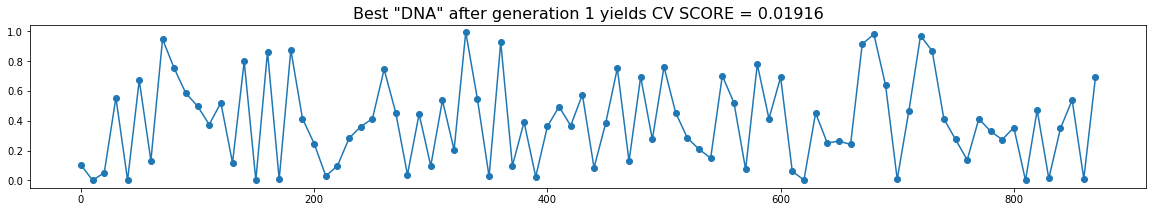

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

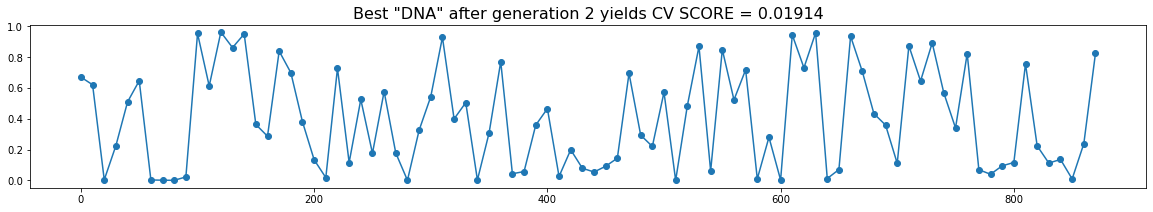

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

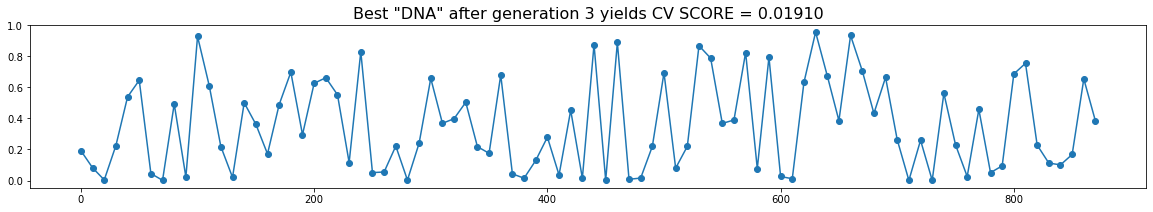

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

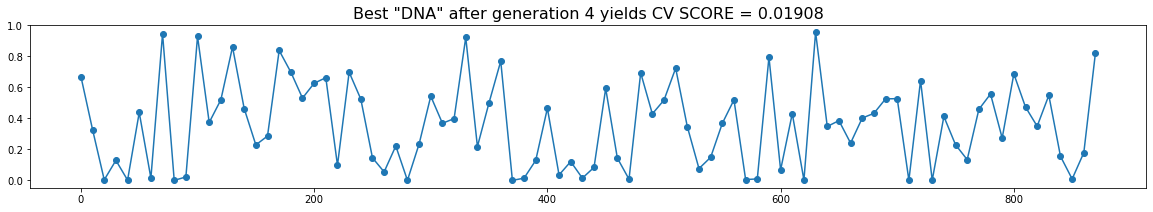

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

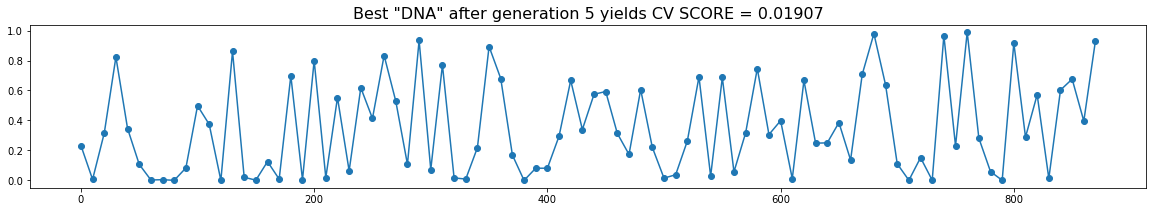

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

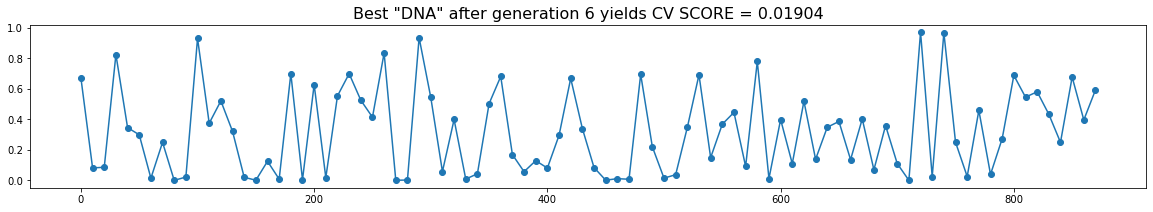

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

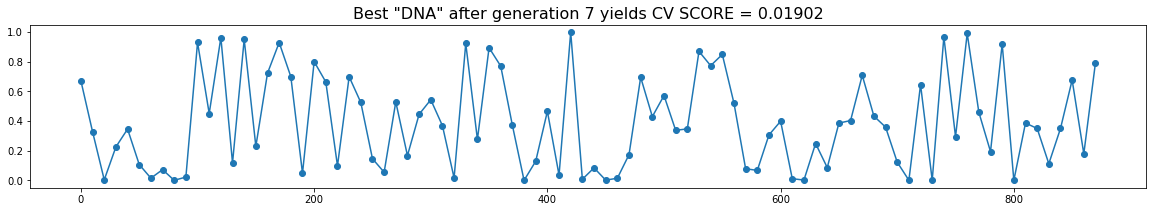

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

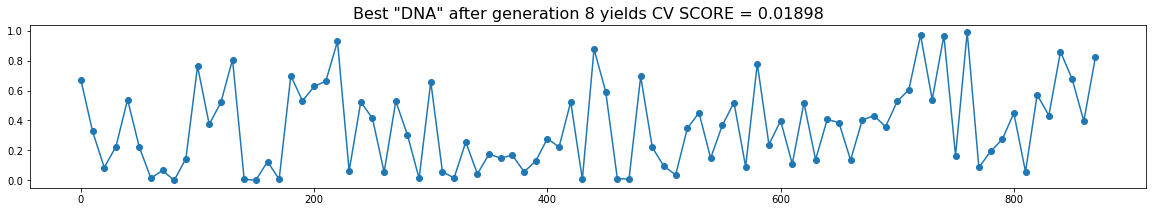

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

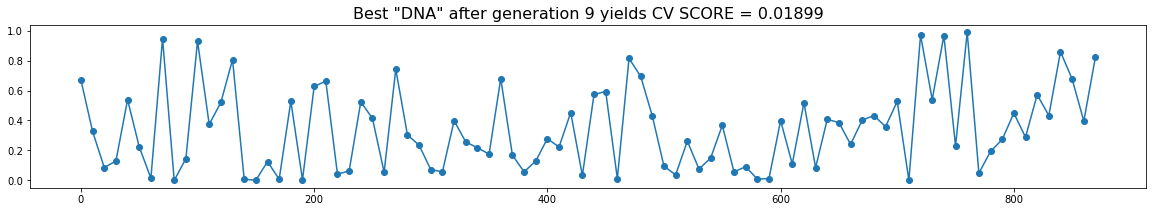

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

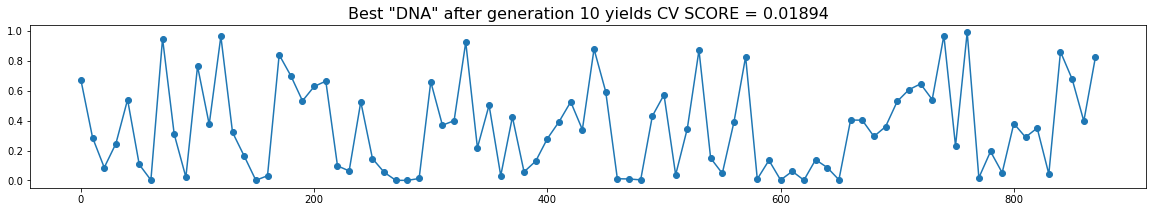

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

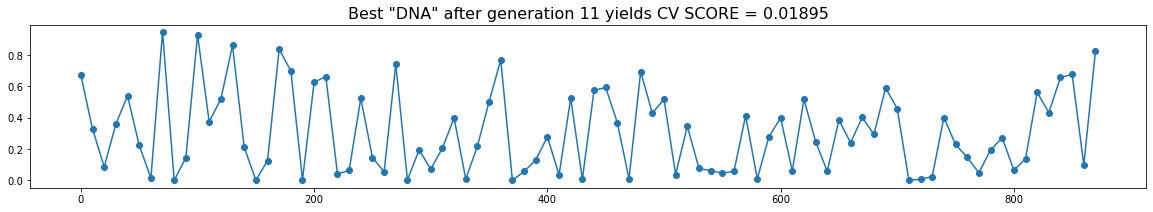

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

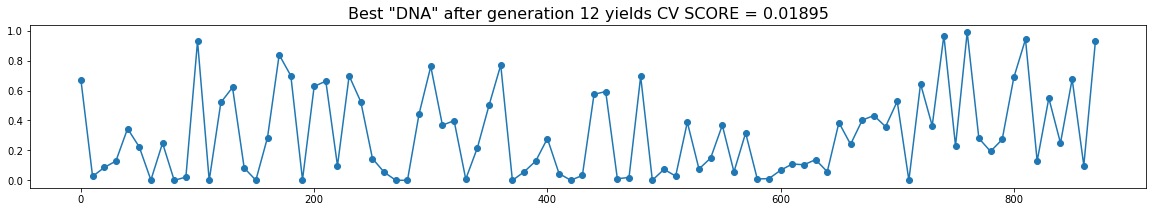

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

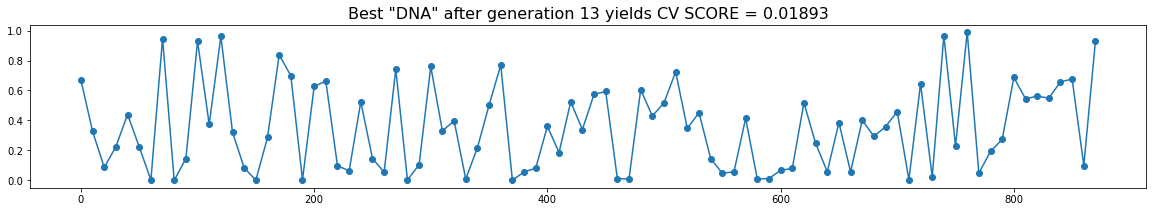

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

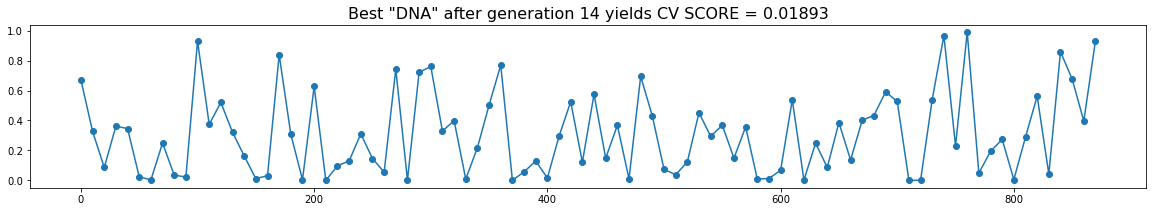

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

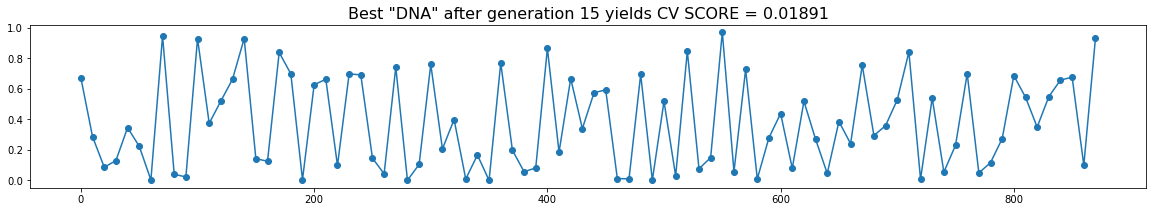

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

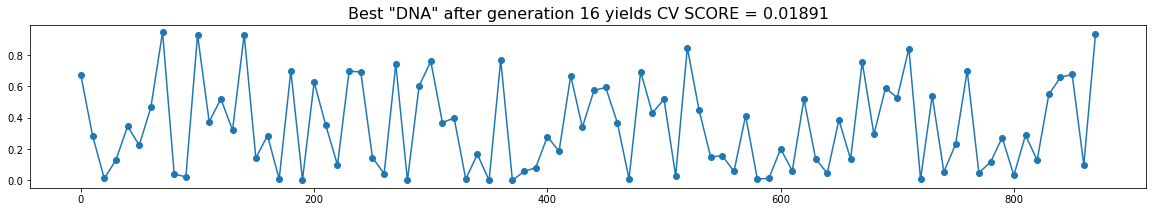

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

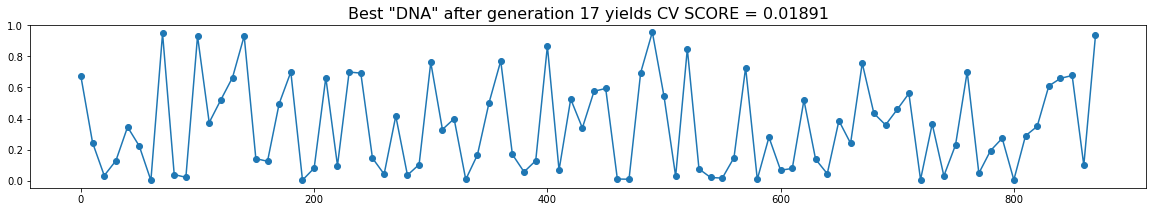

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

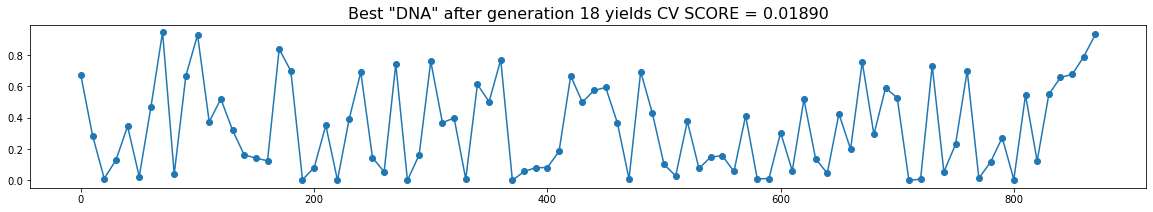

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

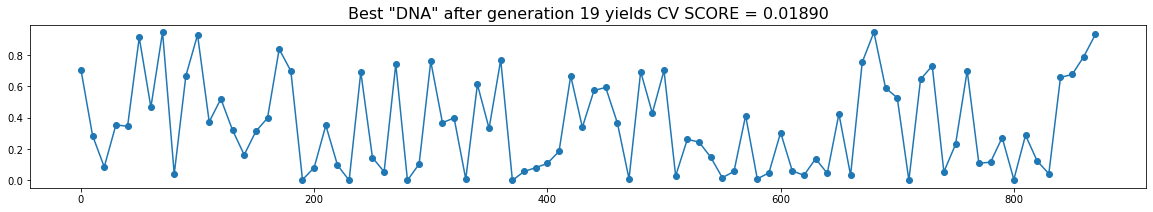

Evolving...
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , 21 , 22 , 23 , 24 , 25 , 26 , 27 , 28 , 29 , 30 , 31 , 32 , 33 , 34 , 35 , 36 , 37 , 38 , 39 , 40 , 41 , 42 , 43 , 44 , 45 , 46 , 47 , 48 , 49 , 50 , 51 , 52 , 53 , 54 , 55 , 56 , 57 , 58 , 59 , 60 , 61 , 62 , 63 , 64 , 65 , 66 , 67 , 68 , 69 , 70 , 71 , 72 , 73 , 74 , 75 , 76 , 77 , 78 , 79 , 80 , 81 , 82 , 83 , 84 , 85 , 86 , 87 , 88 , 89 , 90 , 91 , 92 , 93 , 94 , 95 , 96 , 97 , 98 , 99 , 

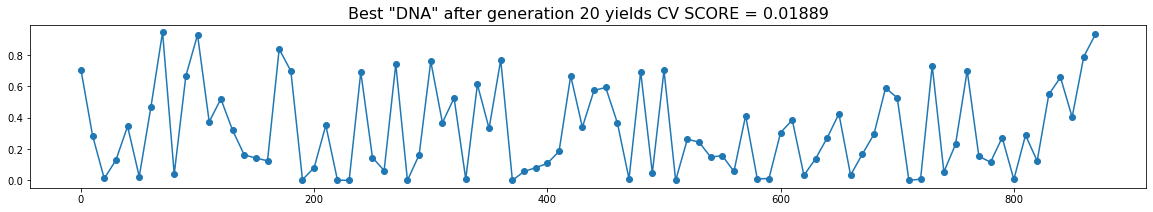

CPU times: user 2h 48min 30s, sys: 1h 1min 50s, total: 3h 50min 20s
Wall time: 3h 52min 43s


In [6]:
%%time
for jj in range(GENERATIONS):

    # ALL PREVIOUS POPULATION "DNA" AND CV SCORES
    df = pd.DataFrame(data=dna)
    df['cv'] = cvs
    df.sort_values('cv',inplace=True)
    print('Evolving...')

    # GENERATE AND EVALUATE CHILDREN
    for k in range(POPULATION):
        print(k,', ',end='')
        
        # GENERATE CHILD
        if jj!=0:
            parent1 = k//PARENTS; parent2 = k%PARENTS
            TMP = np.random.randint(0,2,875)
            dna[k,] = TMP * df.iloc[parent1,:-1] + (1-TMP) * df.iloc[parent2,:-1]
            x = np.random.uniform(0,1,875)
            IDX = np.where(x<MUTATE)[0]
            dna[k,IDX] = np.random.uniform(0,1,len(IDX))**2.0
        else:
            dna[k,] = df.iloc[k,:-1]
        
        # KNN WEIGHTS
        WGT = dna[k,]
        # WEIGHTS FOR CP_TYPE, CP_TIME, CP_DOSE
        WGT[0]= 100 ; WGT[1] = 12/2; WGT[2] = 5/2

        # KNN KFOLD VALIDATE
        for fold in range(FOLDS):    
            model = cuml.neighbors.KNeighborsClassifier(n_neighbors=1000)
            model.fit( train.loc[ train.fold!=fold, train.columns[1:-1] ].values * WGT,
                       targets.loc[targets.fold!=fold, targets.columns[1:-1] ] )
    
            pp = model.predict_proba( train.loc[ train.fold==fold, train.columns[1:-1] ].values * WGT )
            pp = np.stack( [(1 - pp[x][:,0]) for x in range(len(pp))] ).T
            oof[targets.fold==fold,] = pp
        
        cv_score = log_loss( targets.iloc[:,1:-1].values.flatten(), oof.flatten() )
        cvs[k] = cv_score
        
    # DISPLAY BEST "DNA"
    RES = 10
    idx = np.argmin(cvs)
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(872)[::RES],dna[idx,3:][::RES],'o-')
    plt.title('Best "DNA" after generation %i yields CV SCORE = %.5f'%(jj+1,np.min(cvs)),size=16)
    plt.show()    

# Show all population "DNA" with CV scores
Each row in the dataframe below is one set of weights from our evolved population. The first column indicates the cv score and the next 875 columns are the weights that we scale the 875 features with. (The weights can be thought of as "DNA" in the context of genetic algorithm). We will save the "DNA" to disk.

In [7]:
df = pd.DataFrame(data=dna)
df['cv'] = cvs
df = df[['cv']+list(np.arange(0,875))]
df.sort_values('cv',inplace=True)
df.to_csv('dna.csv',index=False)
df.head()

,cv,0,1,2,3,4,5,6,7,8,...,865,866,867,868,869,870,871,872,873,874
70,0.018891,100.0,6.0,2.5,0.707660,0.005778,0.917778,0.11058,0.290509,0.614093,...,0.408649,0.045356,0.773361,0.780110,0.18913,0.203782,0.404214,0.782403,0.933111,0.640859
9,0.018897,100.0,6.0,2.5,0.707660,0.005778,0.917778,0.11058,0.662555,0.614093,...,0.408649,0.045356,0.773361,0.084869,0.18913,0.203782,0.404214,0.015199,0.933111,0.640859
57,0.018900,100.0,6.0,2.5,0.669894,0.005778,0.917778,0.11058,0.007918,0.614093,...,0.563646,0.045356,0.561449,0.780110,0.18913,0.203782,0.404214,0.149099,0.933111,0.640859
45,0.018900,100.0,6.0,2.5,0.669894,0.029117,0.161159,0.13258,0.662555,0.614093,...,0.408649,0.045356,0.009042,0.780110,0.18913,0.203782,0.404214,0.155647,0.933111,0.640859
40,0.018906,100.0,6.0,2.5,0.707660,0.005778,0.161159,0.13258,0.662555,0.869589,...,0.408649,0.045356,0.773361,0.780110,0.18913,0.203782,0.404214,0.063278,0.933111,0.640859


# Predict Test Data

In [8]:
WGT = df.iloc[0,1:].values
oof = np.zeros((len(train),206))
preds = np.zeros((len(test),206))

for fold in range(FOLDS):
    print('FOLD %i'%(fold+1), ' ', end='')
    
    model = cuml.neighbors.KNeighborsClassifier(n_neighbors=1000)
    model.fit( train.loc[ train.fold!=fold, train.columns[1:-1] ].values * WGT,
               targets.loc[targets.fold!=fold, targets.columns[1:-1] ] )
    
    pp = model.predict_proba( train.loc[ train.fold==fold, train.columns[1:-1] ].values * WGT )
    pp = np.stack( [(1 - pp[x][:,0]) for x in range(len(pp))] ).T
    oof[targets.fold==fold,] = pp
    
    pp = model.predict_proba( test[test.columns[1:]].values * WGT )
    pp = np.stack( [(1 - pp[x][:,0]) for x in range(len(pp))] ).T
    preds += pp/FOLDS    
    
print()
cv_score = log_loss( targets.iloc[:,1:-1].values.flatten(), oof.flatten() )
print('CV SCORE = %.5f'%cv_score)

FOLD 1  FOLD 2  FOLD 3  FOLD 4  FOLD 5  
CV SCORE = 0.01889


# Clip and Submit
If we predict 0 when the true target is 1, we are severly penalized in this competition's metric. Therefore we clip our predictions and observe an increase of CV LB 0.00050! We will save the OOF to disk before clipping.

In [9]:
df_oof = targets.copy()
df_oof.iloc[:,1:-1] = oof
df_oof.to_csv('oof.csv',index=False)

oof = np.clip(oof,0.0005,0.999)
oof[train.cp_type==1,] = 0

cv_score = log_loss( targets.iloc[:,1:-1].values.flatten(), oof.flatten() )
print('CV SCORE with CLIPPING = %.5f'%cv_score)

CV SCORE with CLIPPING = 0.01841


In [10]:
sub = pd.read_csv('../input/lish-moa/sample_submission.csv')
sub.iloc[:,1:] = np.clip(preds,0.0005,0.999)
sub.loc[test.cp_type==1,sub.columns[1:]] = 0
sub.to_csv('submission.csv',index=False)
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001609,0.001609,0.001609,0.015409,0.022409,0.005609,0.003209,0.004009,0.0005,...,0.000500,0.000809,0.001609,0.004009,0.000500,0.000500,0.004809,0.001609,0.002409,0.000500
1,id_001897cda,0.000500,0.001609,0.000500,0.008809,0.018609,0.004809,0.001609,0.006809,0.0005,...,0.000500,0.000500,0.003209,0.001609,0.003209,0.000809,0.005609,0.000500,0.002409,0.002409
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000500,0.000500,0.000809,0.011209,0.021009,0.000500,0.003009,0.006409,0.0005,...,0.000500,0.000500,0.004009,0.005609,0.003209,0.000500,0.004009,0.000500,0.002409,0.001609
4,id_0027f1083,0.003209,0.002409,0.000809,0.013609,0.020809,0.002409,0.005409,0.002809,0.0005,...,0.000809,0.000809,0.003209,0.001609,0.000809,0.000500,0.002409,0.001609,0.001009,0.000500


In [11]:
targets.iloc[:,1:-1].mean()

5-alpha_reductase_inhibitor              0.000714
11-beta-hsd1_inhibitor                   0.000756
acat_inhibitor                           0.001008
acetylcholine_receptor_agonist           0.007979
acetylcholine_receptor_antagonist        0.012640
                                           ...   
ubiquitin_specific_protease_inhibitor    0.000252
vegfr_inhibitor                          0.007139
vitamin_b                                0.001092
vitamin_d_receptor_agonist               0.001638
wnt_inhibitor                            0.001260
Length: 206, dtype: float64

In [12]:
sub.iloc[:,1:].mean()

5-alpha_reductase_inhibitor              0.001644
11-beta-hsd1_inhibitor                   0.001202
acat_inhibitor                           0.001177
acetylcholine_receptor_agonist           0.008938
acetylcholine_receptor_antagonist        0.017790
                                           ...   
ubiquitin_specific_protease_inhibitor    0.000611
vegfr_inhibitor                          0.004356
vitamin_b                                0.001187
vitamin_d_receptor_agonist               0.001222
wnt_inhibitor                            0.001166
Length: 206, dtype: float64